# Analysis Flares

Filtra flares validos por:

- StartTime <= PeakTime <= EndTime
- StartEnd <= 720 m (12h)
- StartEnd <= 180 m (3h) para class < C

## Packages

In [22]:
from datetime import datetime, timedelta
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Cleaned Data:

In [2]:
n=185
# Obtener fecha actual en formato YYYY-MM-DD
#fecha_actual = datetime.now().strftime("%Y-%m-%d")
fecha_actual = "2025-11-04"
window_minutes=30
output_dir = f"{fecha_actual}_Analysis_for_{n}_days"
# Crear carpeta principal (si no existe) y mostrar mensaje
if os.path.exists(output_dir):
    print(f"⚠️ La carpeta principal ya existía: {output_dir}")
else:
    os.makedirs(output_dir, exist_ok=True)
    print(f"📁 Carpeta principal creada: {output_dir}")

# Path of cleaned data in csv
csv_path_full = f"{fecha_actual}_Analysis_for_{n}_days/all_df_full_{n}_cleaned.csv"
csv_path_flares = f"{fecha_actual}_Analysis_for_{n}_days/all_df_flares_{n}_cleaned.csv"
# Verificar existencia de archivos y avisar
if not os.path.exists(csv_path_full):
    print(f"⚠️ No se encontró el archivo GOES: {csv_path_full}")
else:
    print(f"✅ Archivo GOES encontrado: {csv_path_full}")

if not os.path.exists(csv_path_flares):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_flares}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_flares}")
df_full_clean = pd.read_csv(csv_path_full)
df_flares_clean = pd.read_csv(csv_path_flares)

⚠️ La carpeta principal ya existía: 2025-11-04_Analysis_for_185_days
✅ Archivo GOES encontrado: 2025-11-04_Analysis_for_185_days/all_df_full_185_cleaned.csv
✅ Archivo de flares encontrado: 2025-11-04_Analysis_for_185_days/all_df_flares_185_cleaned.csv


In [4]:
df_flares_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2022 entries, 0 to 2021
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   StartTime    2022 non-null   object
 1   EndTime      2022 non-null   object
 2   Class        2022 non-null   object
 3   Observatory  2022 non-null   object
 4   PeakTime     2022 non-null   object
dtypes: object(5)
memory usage: 79.1+ KB


### Additional columns for flares

In [5]:

# Convertir StartTime y EndTime a datetime si aún no lo están

df_flares_clean['StartTime'] = pd.to_datetime(df_flares_clean['StartTime'])
df_flares_clean['PeakTime'] = pd.to_datetime(df_flares_clean['PeakTime'])
df_flares_clean['EndTime'] = pd.to_datetime(df_flares_clean['EndTime'])

# Calcular las nuevas columnas en minutos (puedes cambiar a segundos o horas si quieres)
df_flares_clean['StartPeak'] = (df_flares_clean['PeakTime'] - df_flares_clean['StartTime']).dt.total_seconds() / 60
df_flares_clean['StartEnd'] = (df_flares_clean['EndTime'] - df_flares_clean['StartTime']).dt.total_seconds() / 60
df_flares_clean['PeakEnd'] = (df_flares_clean['EndTime'] - df_flares_clean['PeakTime']).dt.total_seconds() / 60

#Reordena columnas
df_flares_clean = df_flares_clean[['StartTime', 'PeakTime', 'EndTime',
                                   'Class', 'Observatory', 'StartPeak', 'PeakEnd', 'StartEnd']]


df_flares_clean.head()


,StartTime,PeakTime,EndTime,Class,Observatory,StartPeak,PeakEnd,StartEnd
0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,GOES,15.0,12.0,27.0
1,2000-06-06 01:30:00,2000-06-06 01:49:00,2000-06-06 02:01:00,C2.4,GOES,19.0,12.0,31.0
2,2000-06-06 08:06:00,2000-06-06 08:16:00,2000-06-06 08:34:00,C2.8,GOES,10.0,18.0,28.0
3,2000-06-06 08:47:00,2000-06-06 08:51:00,2000-06-06 08:54:00,C2.4,GOES,4.0,3.0,7.0
4,2000-06-06 11:23:00,2000-06-06 11:27:00,2000-06-06 11:29:00,C1.8,GOES,4.0,2.0,6.0


### Revisión de datos

In [7]:
df_flares_clean.sort_values(by='StartEnd', ascending=False)[:5]

,StartTime,PeakTime,EndTime,Class,Observatory,StartPeak,PeakEnd,StartEnd
1685,2024-06-01 01:30:00,2024-06-02 19:39:00,2024-06-02 20:28:00,M7.3,GOES,2529.0,49.0,2578.0
1789,2024-09-14 03:10:00,2024-09-14 04:31:00,2024-09-14 07:22:00,M1.0,GOES,81.0,171.0,252.0
72,2000-11-26 06:19:00,2000-11-26 08:46:00,2000-11-26 10:30:00,C3.6,GOES,147.0,104.0,251.0
1370,2023-08-05 06:16:00,2023-08-05 07:18:00,2023-08-05 09:06:00,M1.6,GOES,62.0,108.0,170.0
1122,2017-09-09 22:04:00,2017-09-09 23:53:00,2017-09-10 00:41:00,M1.1,GOES,109.0,48.0,157.0


In [8]:
# Duraciones negativas o extremadamente grandes (> 1 día = 1440 minutos)
problematic = df_flares_clean[
    (df_flares_clean['StartPeak'] < 0) | (df_flares_clean['PeakEnd'] < 0) |
    (df_flares_clean['StartPeak'] > 1440) | (df_flares_clean['PeakEnd'] > 1440) |
    (df_flares_clean['StartEnd'] > 1440)]
problematic[['StartTime', 'PeakTime', 'EndTime', 'StartPeak', 'PeakEnd', 'StartEnd', 'Class']]

,StartTime,PeakTime,EndTime,StartPeak,PeakEnd,StartEnd,Class
337,2002-08-21 23:57:00,2002-08-20 04:55:45,2002-08-22 00:03:00,-2581.25,2587.25,6.0,C3.1
1685,2024-06-01 01:30:00,2024-06-02 19:39:00,2024-06-02 20:28:00,2529.00,49.00,2578.0,M7.3


In [9]:
len(problematic)

2

In [10]:
# Filas que no cumplen StartTime < PeakTime < EndTime
invalid_order = df_flares_clean[~((df_flares_clean['StartTime'] < df_flares_clean['PeakTime']) & 
                                  (df_flares_clean['PeakTime'] < df_flares_clean['EndTime']))]

# Contar cuántas son
num_flares = len(df_flares_clean)
num_invalid = len(invalid_order)
print(f"Filas con orden de tiempo inválido: {num_invalid} de {num_flares}")

# Mostrar esas filas
invalid_order[['StartTime', 'PeakTime', 'EndTime', 'StartPeak', 'PeakEnd', 'StartEnd']][:30]

Filas con orden de tiempo inválido: 1 de 2022


,StartTime,PeakTime,EndTime,StartPeak,PeakEnd,StartEnd
337,2002-08-21 23:57:00,2002-08-20 04:55:45,2002-08-22 00:03:00,-2581.25,2587.25,6.0


In [11]:
# Filas que no cumplen StartTime < PeakTime < EndTime
invalid_order = df_flares_clean[~((df_flares_clean['StartTime'] <= df_flares_clean['PeakTime']) & 
                                  (df_flares_clean['PeakTime'] <= df_flares_clean['EndTime']))]

# Contar cuántas son
num_flares = len(df_flares_clean)
num_invalid = len(invalid_order)
print(f"Filas con orden de tiempo inválido: {num_invalid} de {num_flares}")

# Mostrar esas filas
invalid_order[['StartTime', 'PeakTime', 'EndTime', 'StartPeak', 'PeakEnd', 'StartEnd', 'Class']][:30]

Filas con orden de tiempo inválido: 1 de 2022


,StartTime,PeakTime,EndTime,StartPeak,PeakEnd,StartEnd,Class
337,2002-08-21 23:57:00,2002-08-20 04:55:45,2002-08-22 00:03:00,-2581.25,2587.25,6.0,C3.1


## Cleaning by duration and class

In [12]:
# Extraer letra y número de la clase
letters = df_flares_clean['Class'].str[0]       # 'A', 'B', 'C', 'M', 'X'
numbers = df_flares_clean['Class'].str[1:].astype(float)

# Condición de duración según clase
duration_by_class = ((letters < 'C') & (df_flares_clean['StartEnd'] <= 180)) | \
                    ((letters >= 'C') & (df_flares_clean['StartEnd'] <= 720))

# Condición de orden correcto
valid_order = (df_flares_clean['StartTime'] <= df_flares_clean['PeakTime']) & \
              (df_flares_clean['PeakTime'] <= df_flares_clean['EndTime'])

# Condición de duraciones razonables (también manteniendo PeakEnd y StartPeak ≤ 720)
valid_duration = (df_flares_clean['StartPeak'] <= 720) & \
                 (df_flares_clean['PeakEnd'] <= 720) & \
                 duration_by_class

# Filas que cumplen todas las condiciones
df_flares_valid = df_flares_clean[valid_order & valid_duration]

# Número de filas válidas
num_flares = len(df_flares_clean)
valid_flares = len(df_flares_valid)
print(f"Valid flares: {valid_flares} of {num_flares}. Invalid flares: {num_flares - valid_flares}")

Valid flares: 2020 of 2022. Invalid flares: 2


In [13]:
df_flares_valid.sort_values(by='StartEnd', ascending=False)[:5]

,StartTime,PeakTime,EndTime,Class,Observatory,StartPeak,PeakEnd,StartEnd
1789,2024-09-14 03:10:00,2024-09-14 04:31:00,2024-09-14 07:22:00,M1.0,GOES,81.0,171.0,252.0
72,2000-11-26 06:19:00,2000-11-26 08:46:00,2000-11-26 10:30:00,C3.6,GOES,147.0,104.0,251.0
1370,2023-08-05 06:16:00,2023-08-05 07:18:00,2023-08-05 09:06:00,M1.6,GOES,62.0,108.0,170.0
1122,2017-09-09 22:04:00,2017-09-09 23:53:00,2017-09-10 00:41:00,M1.1,GOES,109.0,48.0,157.0
1958,2025-01-04 14:11:00,2025-01-04 15:09:00,2025-01-04 16:34:00,C9.3,GOES,58.0,85.0,143.0


In [14]:
# 1) Crear un Flare_ID único basado en PeakTime
df_flares_valid = df_flares_valid.sort_values('PeakTime').reset_index(drop=True)
df_flares_valid['Flare_ID'] = ['Flare_' + pt.strftime('%Y%m%d') + f'_{i}' 
                               for i, pt in enumerate(df_flares_valid['PeakTime'])]

# 2) Separar clase en letra y número
df_flares_valid['ClassLetter'] = df_flares_valid['Class'].str[0]
df_flares_valid['ClassNumber'] = df_flares_valid['Class'].str[1:].astype(float)

df_flares_valid.head()

,StartTime,PeakTime,EndTime,Class,Observatory,StartPeak,PeakEnd,StartEnd,Flare_ID,ClassLetter,ClassNumber
0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,GOES,15.0,12.0,27.0,Flare_20000606_0,C,4.6
1,2000-06-06 01:30:00,2000-06-06 01:49:00,2000-06-06 02:01:00,C2.4,GOES,19.0,12.0,31.0,Flare_20000606_1,C,2.4
2,2000-06-06 08:06:00,2000-06-06 08:16:00,2000-06-06 08:34:00,C2.8,GOES,10.0,18.0,28.0,Flare_20000606_2,C,2.8
3,2000-06-06 08:47:00,2000-06-06 08:51:00,2000-06-06 08:54:00,C2.4,GOES,4.0,3.0,7.0,Flare_20000606_3,C,2.4
4,2000-06-06 11:23:00,2000-06-06 11:27:00,2000-06-06 11:29:00,C1.8,GOES,4.0,2.0,6.0,Flare_20000606_4,C,1.8


In [15]:
df_flares_valid.iloc[200:]

,StartTime,PeakTime,EndTime,Class,Observatory,StartPeak,PeakEnd,StartEnd,Flare_ID,ClassLetter,ClassNumber
200,2001-10-22 17:44:00,2001-10-22 17:59:00,2001-10-22 18:14:00,X1.2,GOES,15.0,15.0,30.0,Flare_20011022_200,X,1.2
201,2001-10-22 20:57:00,2001-10-22 21:06:00,2001-10-22 21:14:00,C7.9,GOES,9.0,8.0,17.0,Flare_20011022_201,C,7.9
202,2001-10-24 23:59:00,2001-10-25 00:03:00,2001-10-25 00:06:00,C5.3,GOES,4.0,3.0,7.0,Flare_20011025_202,C,5.3
203,2001-10-25 03:22:00,2001-10-25 03:31:00,2001-10-25 03:45:00,C4.8,GOES,9.0,14.0,23.0,Flare_20011025_203,C,4.8
204,2001-10-25 05:16:00,2001-10-25 05:21:00,2001-10-25 05:25:00,C5.2,GOES,5.0,4.0,9.0,Flare_20011025_204,C,5.2
...,...,...,...,...,...,...,...,...,...,...,...
2015,2025-06-19 07:13:00,2025-06-19 07:27:00,2025-06-19 07:51:00,C6.0,GOES,14.0,24.0,38.0,Flare_20250619_2015,C,6.0
2016,2025-06-19 08:23:00,2025-06-19 08:27:00,2025-06-19 08:29:00,C2.3,GOES,4.0,2.0,6.0,Flare_20250619_2016,C,2.3
2017,2025-06-19 09:06:00,2025-06-19 09:17:00,2025-06-19 09:53:00,C7.9,GOES,11.0,36.0,47.0,Flare_20250619_2017,C,7.9
2018,2025-06-19 10:31:00,2025-06-19 10:37:00,2025-06-19 10:39:00,C1.9,GOES,6.0,2.0,8.0,Flare_20250619_2018,C,1.9


In [16]:
# 3) Agrupación opcional por subclases
group_ranges = {
    "A": [(1, 4.9), (5, 9.9)],
    "B": [(1, 4.9), (5, 9.9)],
    "C": [(1, 4.9), (5, 9.9)],
    "M": [(1, 4.9), (5, 9.9)],
    "X": [(1, 4.9), (5, 1000)],
}

def assign_flare_group(flare_class):
    if not isinstance(flare_class, str) or len(flare_class) < 2:
        return flare_class
    letter = flare_class[0]
    try:
        number = float(flare_class[1:])
    except:
        return flare_class
    for low, high in group_ranges.get(letter, []):
        if low <= number <= high:
            return f"{letter}{low}-{high if high < 1000 else '+'}"
    return flare_class

group_subclasses = True
if group_subclasses:
    df_flares_valid["ClassGroup"] = df_flares_valid["Class"].apply(lambda x: assign_flare_group(str(x)))
else:
    df_flares_valid["ClassGroup"] = df_flares_valid["Class"].str[0]

df_flares_valid.head()

,StartTime,PeakTime,EndTime,Class,Observatory,StartPeak,PeakEnd,StartEnd,Flare_ID,ClassLetter,ClassNumber,ClassGroup
0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,GOES,15.0,12.0,27.0,Flare_20000606_0,C,4.6,C1-4.9
1,2000-06-06 01:30:00,2000-06-06 01:49:00,2000-06-06 02:01:00,C2.4,GOES,19.0,12.0,31.0,Flare_20000606_1,C,2.4,C1-4.9
2,2000-06-06 08:06:00,2000-06-06 08:16:00,2000-06-06 08:34:00,C2.8,GOES,10.0,18.0,28.0,Flare_20000606_2,C,2.8,C1-4.9
3,2000-06-06 08:47:00,2000-06-06 08:51:00,2000-06-06 08:54:00,C2.4,GOES,4.0,3.0,7.0,Flare_20000606_3,C,2.4,C1-4.9
4,2000-06-06 11:23:00,2000-06-06 11:27:00,2000-06-06 11:29:00,C1.8,GOES,4.0,2.0,6.0,Flare_20000606_4,C,1.8,C1-4.9


### reodenar columnas

In [17]:
# Definir el nuevo orden de columnas
new_order = [
    "Flare_ID", "StartTime", "PeakTime", "EndTime", "Class",
    "ClassLetter", "ClassNumber", "ClassGroup",
    "Observatory", "StartPeak", "PeakEnd", "StartEnd"
]
# Reordenar el DataFrame
df_flares_valid = df_flares_valid[new_order]

df_flares_valid.head()

,Flare_ID,StartTime,PeakTime,EndTime,Class,ClassLetter,ClassNumber,ClassGroup,Observatory,StartPeak,PeakEnd,StartEnd
0,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0
1,Flare_20000606_1,2000-06-06 01:30:00,2000-06-06 01:49:00,2000-06-06 02:01:00,C2.4,C,2.4,C1-4.9,GOES,19.0,12.0,31.0
2,Flare_20000606_2,2000-06-06 08:06:00,2000-06-06 08:16:00,2000-06-06 08:34:00,C2.8,C,2.8,C1-4.9,GOES,10.0,18.0,28.0
3,Flare_20000606_3,2000-06-06 08:47:00,2000-06-06 08:51:00,2000-06-06 08:54:00,C2.4,C,2.4,C1-4.9,GOES,4.0,3.0,7.0
4,Flare_20000606_4,2000-06-06 11:23:00,2000-06-06 11:27:00,2000-06-06 11:29:00,C1.8,C,1.8,C1-4.9,GOES,4.0,2.0,6.0


In [18]:
#Resumen estadístico
df_flares_valid[['StartPeak', 'StartEnd', 'PeakEnd']].describe()

,StartPeak,StartEnd,PeakEnd
count,2020.000000,2020.000000,2020.000000
mean,11.029703,20.559406,9.529703
std,10.924030,18.989790,10.004982
min,1.000000,2.000000,1.000000
25%,5.000000,10.000000,4.000000
50%,8.000000,15.000000,7.000000
75%,13.000000,24.000000,11.000000
max,147.000000,252.000000,171.000000


## Flare valid guardado

In [19]:
# Guardar en CSV
output_filename = f"df_flares_{n}_valid.csv"
output_path = os.path.join(output_dir, output_filename)
df_flares_valid.to_csv(output_path, index=False)
print(f"\nFile saved to: {output_path}")


File saved to: 2025-11-04_Analysis_for_185_days/df_flares_185_valid.csv


## Flare analysis graphs

In [20]:
# Carpeta principal donde se guardarán las gráficas
graphics_dir = os.path.join(output_dir, "Flare_analysis_graphs")

# Crear carpeta si no existe y avisar
if not os.path.exists(graphics_dir):
    os.makedirs(graphics_dir)
    print(f"Carpeta creada: {graphics_dir}")
else:
    print(f"La carpeta ya existía: {graphics_dir}")

Carpeta creada: 2025-11-04_Analysis_for_185_days/Flare_analysis_graphs


### Histograma de tiempos para todos!


File saved to: 2025-11-04_Analysis_for_185_days/Flare_analysis_graphs/Histogram_Flares_Times.png


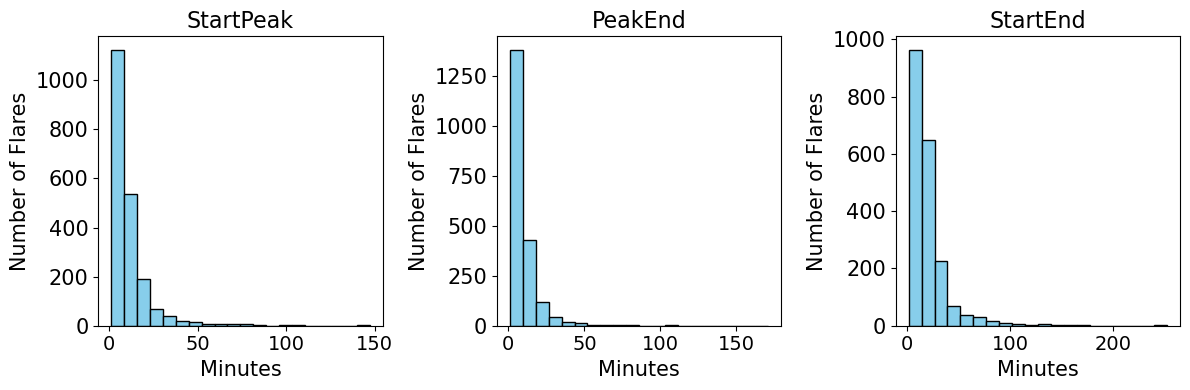

In [31]:
# Histograma
plt.figure(figsize=(12,4))

for i, col in enumerate(['StartPeak', 'PeakEnd', 'StartEnd'], 1):
    plt.subplot(1, 3, i)
    plt.hist(df_flares_valid[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(col)
    plt.xlabel('Minutes')
    plt.ylabel('Number of Flares')


plt.tight_layout()

# Guardar figura
output_name = f"Histogram_Flares_Times.png"
output_path = os.path.join(graphics_dir, output_name)
plt.savefig(output_path, dpi=300, bbox_inches="tight")
print(f"\nFile saved to: {output_path}")

plt.show()


### histogramas de tiempos por clase de flare

In [34]:
def plot_flare_times_histograms(df, class_column="ClassLetter", class_filter=None, graphics_dir="."):
    """
    Genera histogramas de tiempos (StartPeak, PeakEnd, StartEnd) para los flares filtrados por clase.
    
    Parámetros:
        df: DataFrame con los flares.
        class_column: columna a usar para filtrar la clase ('ClassLetter' o 'ClassGroup').
        class_filter: valor de la clase a filtrar, e.g. 'C', 'M', 'C1-4.9'. Si es None, usa todos.
        graphics_dir: carpeta donde guardar la figura.
    """

    # Filtrar DataFrame por clase si se indica
    if class_filter is not None:
        df_plot = df[df[class_column] == class_filter]
        title_suffix = f"Class {class_filter}"
        output_name = f"Histogram_Flares_Times_{class_filter}.png"
    else:
        df_plot = df
        title_suffix = "All Classes"
        output_name = f"Histogram_Flares_Times_All.png"

    if df_plot.empty:
        print(f"No flares found for {title_suffix}.")
        return

    # Crear la figura con 3 subplots
    plt.figure(figsize=(12,4))
    time_cols = ['StartPeak', 'PeakEnd', 'StartEnd']

    for i, col in enumerate(time_cols, 1):
        plt.subplot(1, 3, i)
        plt.hist(df_plot[col], bins=20, color='skyblue', edgecolor='black')
        plt.title(f"{col} ({title_suffix})")
        plt.xlabel('Minutes')
        plt.ylabel('Number of Flares')

    plt.tight_layout()

    # Guardar figura
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    print(f"\nFile saved to: {output_path}")

    plt.show()



File saved to: 2025-11-04_Analysis_for_185_days/Flare_analysis_graphs/Histogram_Flares_Times_All.png


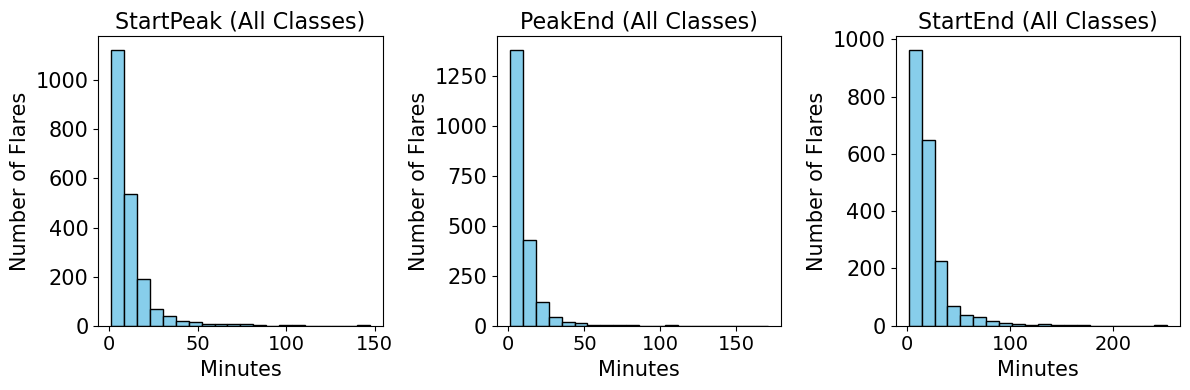

In [36]:
# Histogramas para todas las clases combinadas
plot_flare_times_histograms(df_flares_valid, class_column="ClassLetter", class_filter=None, graphics_dir=graphics_dir)


File saved to: 2025-11-04_Analysis_for_185_days/Flare_analysis_graphs/Histogram_Flares_Times_C.png


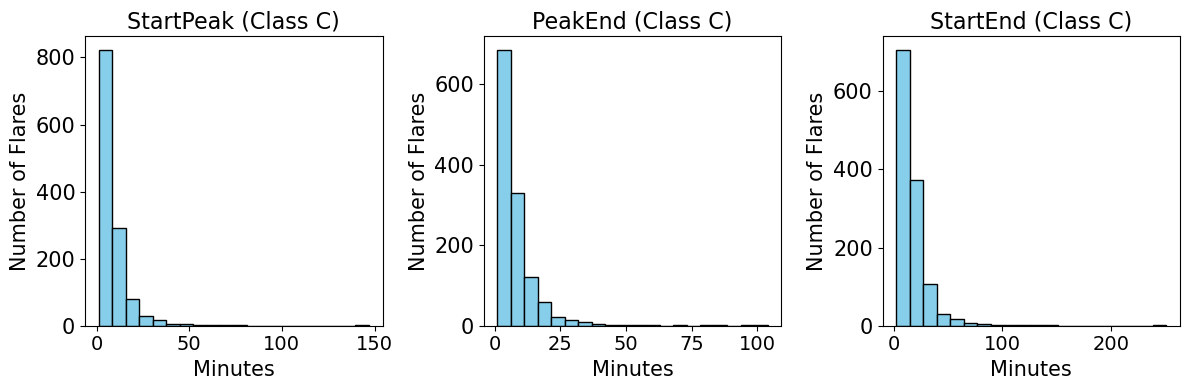

In [35]:
# Histogramas para flares clase C
plot_flare_times_histograms(df_flares_valid, class_column="ClassLetter", class_filter="C", graphics_dir=graphics_dir)



File saved to: 2025-11-04_Analysis_for_185_days/Flare_analysis_graphs/Histogram_Flares_Times_M.png


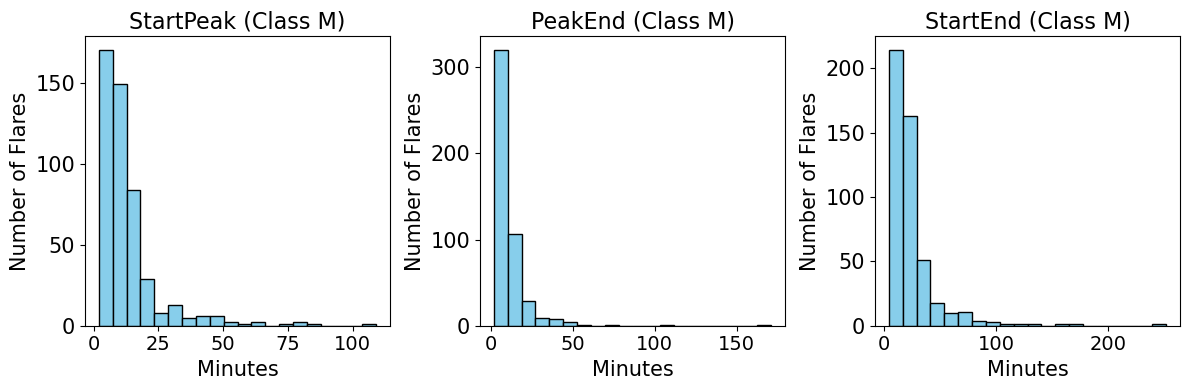

In [37]:
# Histogramas para flares clase M
plot_flare_times_histograms(df_flares_valid, class_column="ClassLetter", class_filter="M", graphics_dir=graphics_dir)


File saved to: 2025-11-04_Analysis_for_185_days/Flare_analysis_graphs/Histogram_Flares_Times_X.png


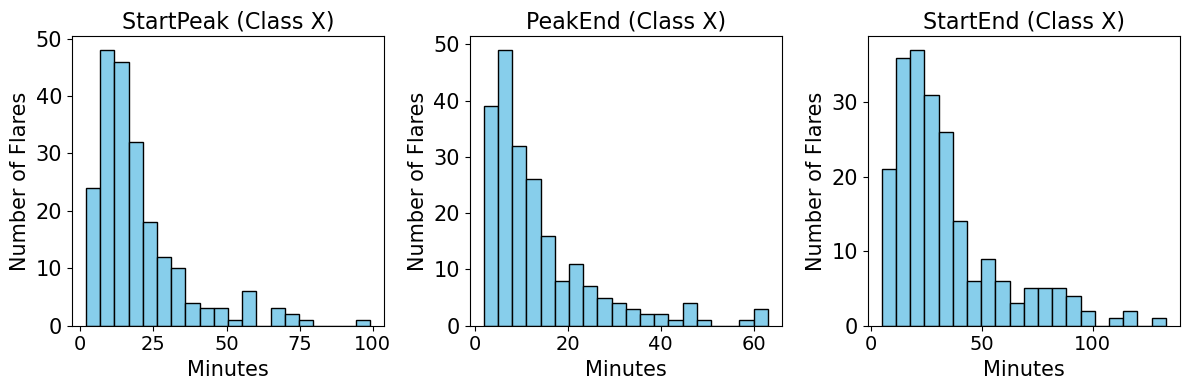

In [38]:
# Histogramas para flares clase X
plot_flare_times_histograms(df_flares_valid, class_column="ClassLetter", class_filter="X", graphics_dir=graphics_dir)


File saved to: 2025-11-04_Analysis_for_185_days/Flare_analysis_graphs/Histogram_Flares_Times_C1-4.9.png


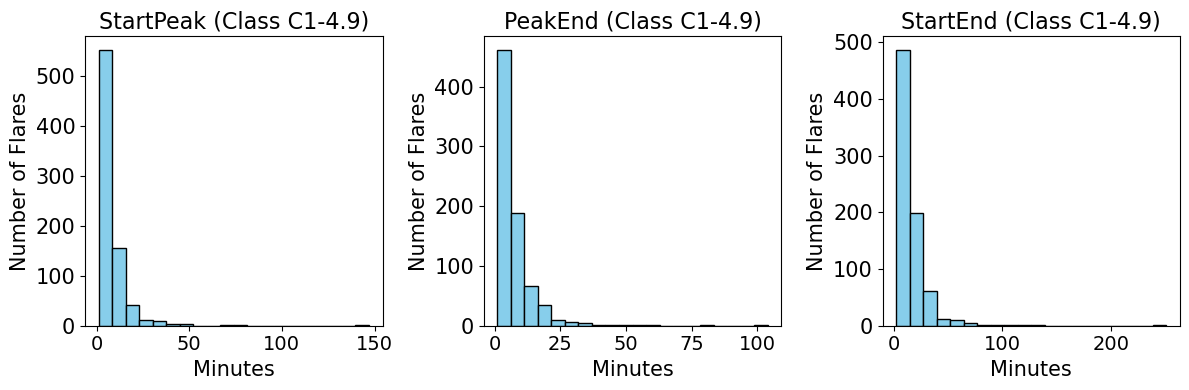

In [46]:
plot_flare_times_histograms(df_flares_valid, class_column="ClassGroup", class_filter="C1-4.9", graphics_dir=graphics_dir)


### histogramas de tiempo todos juntos por colores

In [39]:
def plot_all_classes_histograms(df, class_column="ClassLetter", graphics_dir="."):
    """
    Genera histogramas superpuestos de StartPeak, PeakEnd y StartEnd
    para todas las clases presentes en el DataFrame, usando colores diferentes.
    """

    # Definir colores para clases
    base_colors = {
        "A": "skyblue",
        "B": "mediumseagreen",
        "C": "gold",
        "M": "darkorange",
        "X": "tomato"
    }

    time_cols = ['StartPeak', 'PeakEnd', 'StartEnd']
    classes = sorted(df[class_column].unique())
    
    plt.figure(figsize=(15, 4))

    for i, col in enumerate(time_cols, 1):
        plt.subplot(1, 3, i)
        for cls in classes:
            df_cls = df[df[class_column] == cls]
            plt.hist(df_cls[col], bins=20, alpha=0.5, label=cls,
                     color=base_colors.get(cls, "gray"), edgecolor='black')
        plt.title(col)
        plt.xlabel('Minutes')
        plt.ylabel('Number of Flares')
        plt.legend(title=class_column)

    plt.tight_layout()

    # Guardar figura
    output_name = f"Histogram_Flares_Times_All_Classes.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    print(f"\nFile saved to: {output_path}")

    plt.show()



File saved to: 2025-11-04_Analysis_for_185_days/Flare_analysis_graphs/Histogram_Flares_Times_All_Classes.png


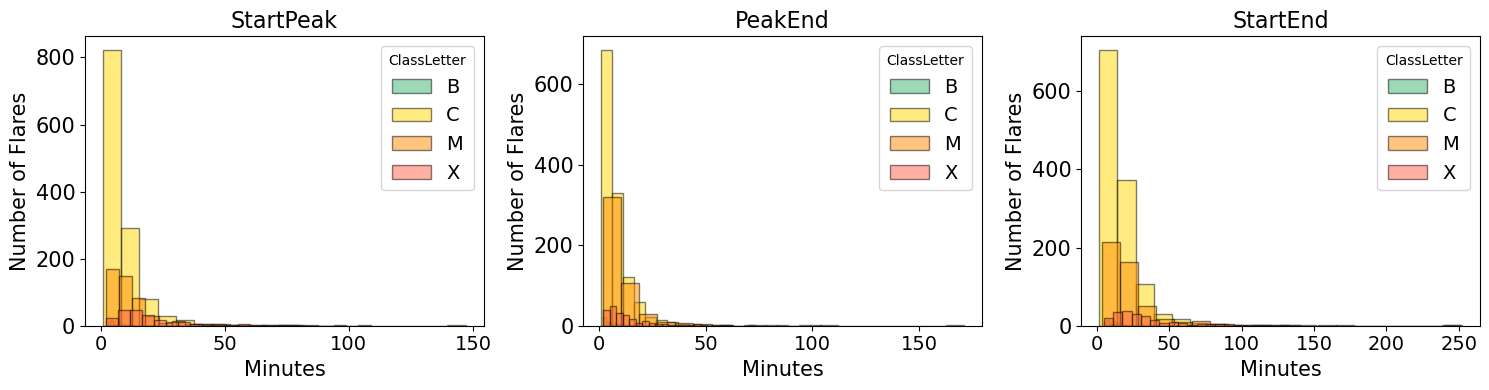

In [41]:
plot_all_classes_histograms(df_flares_valid, class_column="ClassLetter", graphics_dir=graphics_dir)


## histogramas por clase de flare

In [42]:

def plot_flare_distribution(df, column="ClassGroup", color_mode="palette:viridis", graphics_dir="."):
    """
    Genera una gráfica de distribución de clases de flares (conteo y porcentaje)
    usando la columna especificada (por defecto 'ClassGroup' o 'ClassLetter').
    """

    if column not in df.columns:
        raise ValueError(f"El DataFrame debe contener la columna '{column}'.")

    # -------------------------------
    # Conteos y porcentajes
    # -------------------------------
    counts = df[column].value_counts().sort_index()
    total_flares = counts.sum()
    percentages = (counts / total_flares * 100).round(1)

    # -------------------------------
    # Imprimir estadísticas
    # -------------------------------
    print(f"\nStatistics for {column}:")
    print(f"{'Class':<10} {'Count':>8} {'Percentage (%)':>15}")
    for cls, cnt, pct in zip(counts.index, counts.values, percentages.values):
        print(f"{cls:<10} {cnt:>8} {pct:>15.1f}")
    print(f"{'Total':<10} {total_flares:>8} {percentages.sum():>15.1f}\n")

    classes = counts.index.tolist()
    values = counts.values.tolist()
    n_bars = len(classes)

    # -------------------------------
    # Colores
    # -------------------------------
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":", 1)[1]
        cmap = plt.cm.get_cmap(cmap_name, n_bars)
        colors = [cmap(i) for i in range(n_bars)]
    elif color_mode.startswith("single:"):
        single = color_mode.split(":", 1)[1]
        colors = [single] * n_bars
    else:
        colors = ["skyblue"] * n_bars

    # -------------------------------
    # Layout
    # -------------------------------
    chart_width = max(8, n_bars * 1.2)
    chart_height = 6
    fontsize = 8
    item_width = 0.25 * fontsize
    usable_width = chart_width * 0.9
    max_cols = int(usable_width / item_width)
    ncol = min(n_bars, max_cols)
    n_rows = int(np.ceil(n_bars / ncol))
    legend_height_ratio = max(0.55, 0.55 * n_rows)

    plt.rcParams.update({
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 14,
        "ytick.labelsize": 15,
        "legend.fontsize": 14
    })

    fig = plt.figure(figsize=(chart_width, chart_height))
    gs = fig.add_gridspec(2, 1, height_ratios=[6, legend_height_ratio], hspace=0.5)

    # -------------------------------
    # Gráfico principal
    # -------------------------------
    ax = fig.add_subplot(gs[0])
    bars = ax.bar(range(n_bars), values, color=colors, edgecolor="black", width=0.9)

    ax.set_xlim(-0.5, n_bars - 0.5)
    ax.set_xticks(range(n_bars))
    ax.set_xticklabels(classes, rotation=0, ha="center")

    y_max = max(values)
    ax.set_ylim(0, y_max * 1.15)

    # Etiquetas de porcentaje sobre barras
    for bar, pct in zip(bars, percentages):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                f"{pct:.1f}%", ha="center", va="bottom", fontsize=14)

    ax.set_ylabel("Number of flares")
    ax.set_xlabel("Flare Class")
    ax.set_title(f"Distribution of Solar Flares by {column}", pad=20)

    ax.text(0.98, 0.95, f"Total flares: {total_flares}",
            transform=ax.transAxes, ha='right', va='top', fontsize=12,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    # -------------------------------
    # Leyenda inferior
    # ------------------------
    ax_leg = fig.add_subplot(gs[1])
    ax_leg.axis("off")

    legend_labels = [f"{cls} (n={counts[cls]})" for cls in classes]
    handles = [plt.Line2D([], [], marker="s", markersize=8, linestyle="",
                          color=colors[i], label=legend_labels[i])
               for i in range(n_bars)]

    ax_leg.legend(handles=handles,
                  loc="center",
                  ncol=ncol,
                  frameon=False,
                  title=f"Number of flares per {column}:",
                  title_fontsize=15)

    # Guardar figura
    output_name = f"flare_distribution_{column}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    print(f"\nFile saved to: {output_path}")

    plt.show()





Statistics for ClassLetter:
Class         Count  Percentage (%)
B                72             3.6
C              1254            62.1
M               480            23.8
X               214            10.6
Total          2020           100.1



/tmp/ipykernel_6651/2756370388.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)



File saved to: 2025-11-04_Analysis_for_185_days/Flare_analysis_graphs/flare_distribution_ClassLetter.png


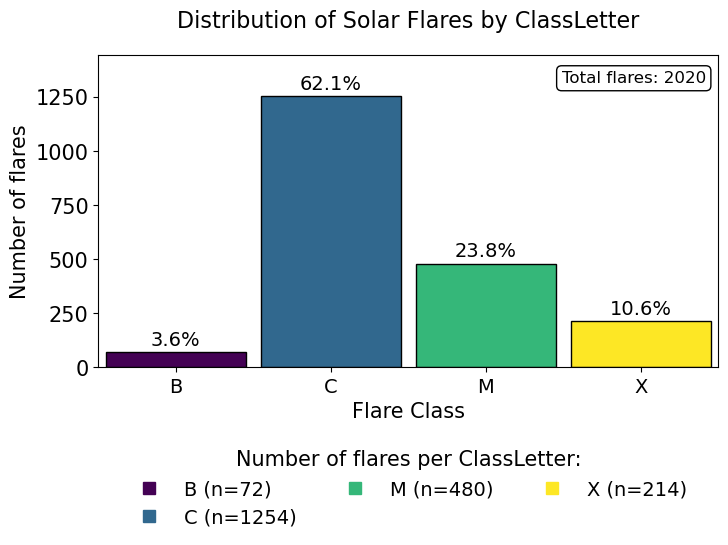

In [43]:
# Histogramas por letra de clase
plot_flare_distribution(df_flares_valid, column="ClassLetter", graphics_dir=graphics_dir)




Statistics for ClassGroup:
Class         Count  Percentage (%)
B1-4.9           15             0.7
B5-9.9           57             2.8
C1-4.9          779            38.6
C5-9.9          475            23.5
M1-4.9          422            20.9
M5-9.9           58             2.9
X1-4.9          190             9.4
X5-+             24             1.2
Total          2020           100.0



/tmp/ipykernel_6651/2756370388.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)



File saved to: 2025-11-04_Analysis_for_185_days/Flare_analysis_graphs/flare_distribution_ClassGroup.png


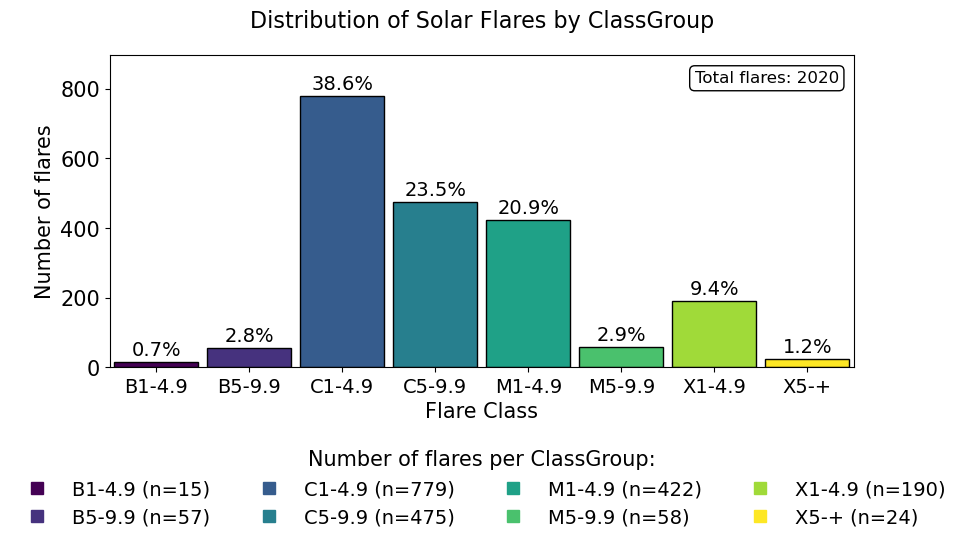

In [44]:
# Histogramas por grupo de clase
plot_flare_distribution(df_flares_valid, column="ClassGroup", graphics_dir=graphics_dir)

## Boxplot

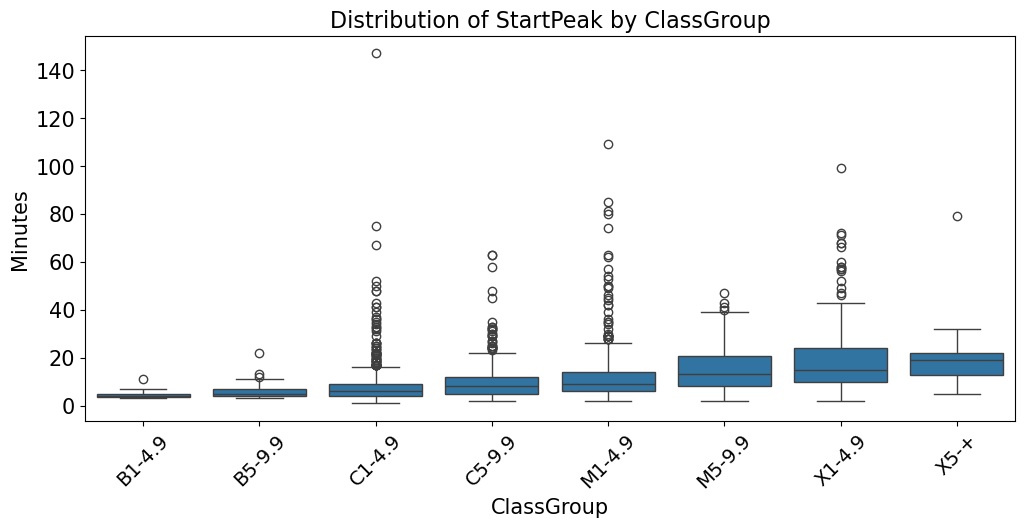

In [48]:
# Orden alfabético de las subclases
order = sorted(df_flares_valid['ClassGroup'].unique())

plt.figure(figsize=(12,5))
sns.boxplot(x="ClassGroup", y="StartPeak", data=df_flares_valid, order=order)
plt.title("Distribution of StartPeak by ClassGroup")
plt.ylabel("Minutes")
plt.xlabel("ClassGroup")
plt.xticks(rotation=45)
plt.show()

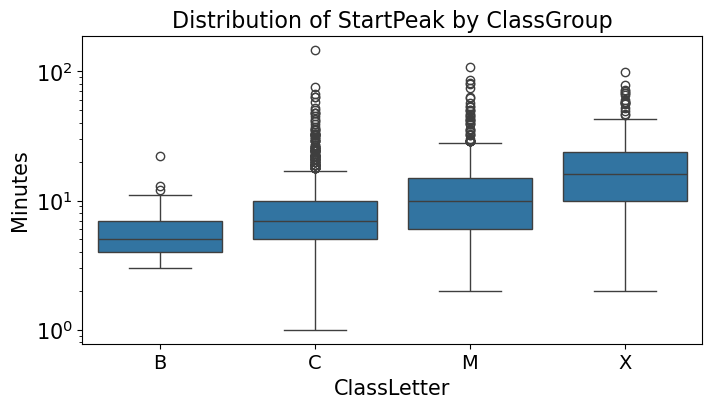

In [57]:
# Orden alfabético de las subclases
order = sorted(df_flares_valid['ClassLetter'].unique())

plt.figure(figsize=(8,4))
sns.boxplot(x="ClassLetter", y="StartPeak", data=df_flares_valid, order=order)
plt.title("Distribution of StartPeak by ClassGroup")
plt.yscale('log')
plt.ylabel("Minutes")
plt.xlabel("ClassLetter")
plt.xticks(rotation=0)
plt.show()

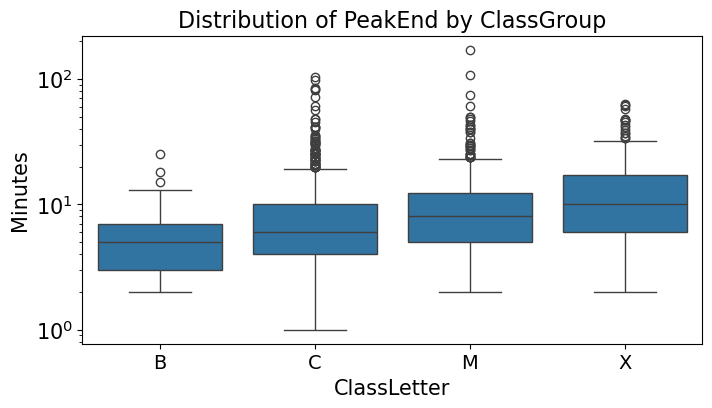

In [59]:
# Orden alfabético de las subclases
order = sorted(df_flares_valid['ClassLetter'].unique())

plt.figure(figsize=(8,4))
sns.boxplot(x="ClassLetter", y="PeakEnd", data=df_flares_valid, order=order)
plt.title("Distribution of PeakEnd by ClassGroup")
plt.yscale('log')
plt.ylabel("Minutes")
plt.xlabel("ClassLetter")
plt.xticks(rotation=0)
plt.show()

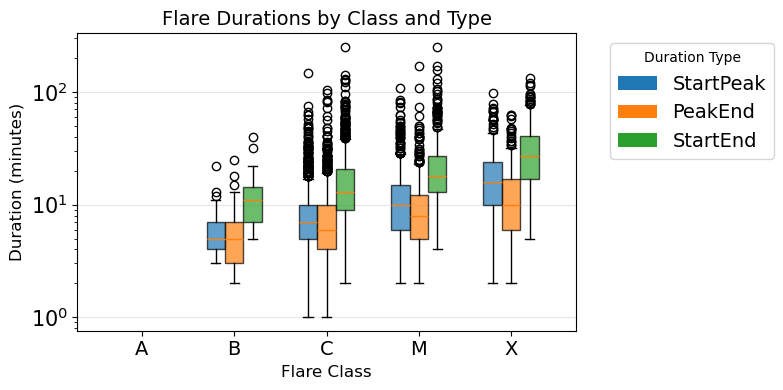

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# -------------------------------
# Configuración de clases y tipos
# -------------------------------
classes = ['A', 'B', 'C', 'M', 'X']
duration_types = ['StartPeak', 'PeakEnd', 'StartEnd']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # azul, naranja, verde

plt.figure(figsize=(8, 4))

# -------------------------------
# Parámetros de posición
# -------------------------------
width = 0.2  # ancho de cada box
positions = []

# Se genera una posición por cada combinación clase-tipo
for i, cls in enumerate(classes):
    base_pos = i  # posición base para esa clase
    for j in range(len(duration_types)):
        positions.append(base_pos + (j - 1) * width)  # centrar los tres tipos

# -------------------------------
# Preparar datos según orden
# -------------------------------
data_to_plot = []
for cls in classes:
    subset = df_flares_valid.loc[df_flares_valid['ClassLetter'] == cls]
    for dur in duration_types:
        data_to_plot.append(subset[dur].dropna())

# -------------------------------
# Dibujar boxplots
# -------------------------------
bp = plt.boxplot(data_to_plot, positions=positions, widths=width, patch_artist=True, showfliers=True)

# Colorear cada tipo (StartPeak, PeakEnd, StartEnd)
for i, patch in enumerate(bp['boxes']):
    color = colors[i % len(duration_types)]
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor("black")

# -------------------------------
# Ajustes de ejes y estilo
# -------------------------------
plt.xticks(np.arange(len(classes)), classes)
plt.yscale('log')
plt.xlabel('Flare Class', fontsize=12)
plt.ylabel('Duration (minutes)', fontsize=12)
plt.title('Flare Durations by Class and Type', fontsize=14)
plt.grid(alpha=0.3, axis='y')

# -------------------------------
# Leyenda manual
# -------------------------------
legend_elements = [Patch(facecolor=colors[i], label=duration_types[i]) for i in range(len(duration_types))]
plt.legend(handles=legend_elements, title='Duration Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
